<a href="https://colab.research.google.com/github/IGieckI/TrAIs/blob/main/TrAIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import copy

# Tris environment
class Tris:
    def __init__(self):
        self.EMPTY_CELL = ' '
        self.board = [[self.EMPTY_CELL, self.EMPTY_CELL, self.EMPTY_CELL], [self.EMPTY_CELL, self.EMPTY_CELL, self.EMPTY_CELL], [self.EMPTY_CELL, self.EMPTY_CELL, self.EMPTY_CELL]]

    def __str__(self) -> str:
        return "  A B C\n" + \
            "1 {}|{}|{}\n".format(self.board[0][0], self.board[0][1], self.board[0][2]) + \
            "  -+-+-\n" + \
            "2 {}|{}|{}\n".format(self.board[1][0], self.board[1][1], self.board[1][2]) + \
            "  -+-+-\n" + \
            "3 {}|{}|{}".format(self.board[2][0], self.board[2][1], self.board[2][2])

    def get_cell_by_id(self, cell_id) -> str:
        return self.board[cell_id//3][cell_id%3]

    def set_cell_by_id(self, cell_id, new_value):
        self.board[cell_id//3][cell_id%3] = new_value

    # note: cell_ids are going from top-left(id:0) to bottom-right(id:8) goind row by row
    def check_winner(self) -> str:
        """Check if there is a winner

        Returns:
            str: return the sign of a winner, EMPTY_CELL if no one wins
        """
        for i in range(3):
            if self.board[i][0] == self.board[i][1] and self.board[i][1] == self.board[i][2] and self.board[i][0] != self.EMPTY_CELL:
                return self.board[i][0]

            if self.board[0][i] == self.board[1][i] and self.board[1][i] == self.board[2][i] and self.board[0][i] != self.EMPTY_CELL:
                return self.board[0][i]

        if (self.board[0][0] == self.board[1][1] and self.board[1][1] == self.board[2][2]) or (self.board[0][2] == self.board[1][1] and self.board[1][1] == self.board[2][0]) and self.board[1][1] != self.EMPTY_CELL:
            return self.board[1][1]
        return self.EMPTY_CELL

    def available_actions(self) -> list[int]:
        """Getter of the available actions (cells without a sign already)

        Returns:
            list[int]: a list of the available actions (cell_ids are going from top-left(id:0) to bottom-right(id:8) increasing from left to right and from top to bottom)
        """
        return [i for i in range(9) if self.get_cell_by_id(i) == self.EMPTY_CELL]

    def step(self, action : int, sign : str) -> "Tris":
        """Execute an action on the board

        Args:
            action (int): cell id to set
            sign (str): sign to set

        Returns:
            Tris: the new board
        """
        new_board = copy.deepcopy(self)

        new_board.set_cell_by_id(action, sign)

        return new_board

    def get_hash(self) -> str:
        hash_string = ''
        for c in [cell for row in self.board for cell in row]:
            hash_string += c
        return hash_string

    def is_playing(self) -> bool:
        return self.check_winner() == self.EMPTY_CELL and len(self.available_actions()) > 0

In [10]:
# The AI model itself
class TrAIs:
    def __init__(self, sign : str):
        self.sign = sign
        self.qTable = {}
        self.history = []

    def get_qRow(self, board : Tris) -> list[float]:
        board_hash = board.get_hash()
        if board_hash in self.qTable:
            row = self.qTable[board_hash]
        else:
            row = np.full(9, 0.6)
            self.qTable[board_hash] = row

        return row

    def set_qElem(self, board : Tris, action: int, new_value : float):
        board_hash = board.get_hash()
        self.qTable[board_hash][action] = new_value

    def get_action(self, board : Tris) -> int:
        """Compute the best possible action for the given board

        Args:
            board (Tris): Current board state

        Returns:
            int: the action to take
        """
        board_hash = board.get_hash()
        while True:
            qRow = self.get_qRow(board)
            index = np.random.choice(np.where(qRow == qRow.max())[0])
            
            if index in board.available_actions():
                return index
            else:
                self.set_qElem(board, index, -100000)

    def train(self, reward : int, learning_rate : float, gamma : float):
        """Update the qTable with the given reward

        Args:
            reward (int): given reward
            learning_rate (float): learning rate value
            gamma (float): gamma value
        """
        for memory in self.history:
            curr_action_value = self.get_qRow(memory[0])[memory[1]]
            new_state_row = self.get_qRow(memory[2])
            new_qValue = curr_action_value + learning_rate * (reward + gamma * max(new_state_row) - curr_action_value)
            self.set_qElem(memory[0], memory[1], new_qValue)
        self.history = []

In [11]:
# Training parameters
NUM_EPISODES = 200000
LEARNING_RATE = 1
LEARNING_RATE_DECAY_RATE = 0.00001
MIN_LEARNING_RATE = 0.01
GAMMA = 0.9

# Percentage he take a random action
EPSILON = 1.0
MIN_EPSILON = 0.005
EPSILON_DECAY_RATE = 0.00001

# Reward values
WIN_REWARD = 10
DRAW_REWARD = 0
LOSS_REWARD = -10

In [12]:
import random
import copy

# TrAIs models to train against eachother
model1 = TrAIs('X')
model2 = TrAIs('O')

# Local variables to compute agent learning
current_episode = 0
current_epsilon = EPSILON
current_learning_rate = LEARNING_RATE

# Performance statistics
m1_wins, ties, m2_wins = [], [], []

while current_episode < NUM_EPISODES:
    # Initialize a new game
    board = Tris()
    turn = True if random.uniform(0, 1) < 0.5 else False

    random_takes, non_random_takes = 0, 0
    
    # Start the game
    while board.is_playing():
        
        # Chance of taking a random choice, useful keeping this high at the beginning of the training to help the agent explore different choices
        if random.uniform(0, 1) < current_epsilon:
            action = random.choice(board.available_actions())
            random_takes+=1
        else:
            action = model1.get_action(board) if turn else model2.get_action(board)
            non_random_takes+=1

        # Apply the chosen action on the game board, taking the reward and initializing the new board
        if turn:
            new_board = board.step(action, model1.sign)
            model1.history.append([copy.deepcopy(board), action, copy.deepcopy(new_board)])
        else:
            new_board = board.step(action, model2.sign)
            model2.history.append([copy.deepcopy(board), action, copy.deepcopy(new_board)])

        # Initialize the new turn
        board = new_board
        turn = not turn

    # Compute the reward for the winner
    winner = board.check_winner()

    stat_index = int(current_episode / 100)
    if len(ties) <= stat_index:
        ties.append(0)
        m1_wins.append(0)
        m2_wins.append(0)

    if winner == ' ':
        ties [stat_index] += 1
        
        m1_reward = DRAW_REWARD
        m2_reward = DRAW_REWARD
    elif winner == model1.sign:
        m1_wins [stat_index] += 1
        
        m1_reward = WIN_REWARD
        m2_reward = LOSS_REWARD
    else:
        m2_wins [stat_index] += 1
        
        m1_reward = LOSS_REWARD
        m2_reward = WIN_REWARD

    # Update models using the given rewards and taken actions (saved in model.history)
    model1.train(m1_reward, current_learning_rate, GAMMA)
    model2.train(m2_reward, current_learning_rate, GAMMA)
    
    current_episode += 1
    
    # Update training parameters
    current_epsilon -= EPSILON_DECAY_RATE
    if current_epsilon < MIN_EPSILON:
        current_epsilon = MIN_EPSILON
    
    current_learning_rate -= LEARNING_RATE_DECAY_RATE
    if current_learning_rate < MIN_LEARNING_RATE:
        current_learning_rate = MIN_LEARNING_RATE
    
    # Print training statistics
    print("N.", current_episode," ", round(current_episode * 100 / NUM_EPISODES,2), "% | Randomness: ",round(random_takes * 100 / (random_takes + non_random_takes)), "% | Ties: ", round(ties[-1] * 100 /(current_episode%100 + 1)), "%")
    print("Curr. epsilon: ", current_epsilon, " Curr. learning rate: ", current_learning_rate)

N. 1   0.0 % | Randomness:  100 % | Ties:  0 %
Curr. epsilon:  0.99999  Curr. learning rate:  0.99999
N. 2   0.0 % | Randomness:  100 % | Ties:  0 %
Curr. epsilon:  0.9999800000000001  Curr. learning rate:  0.9999800000000001
N. 3   0.0 % | Randomness:  100 % | Ties:  25 %
Curr. epsilon:  0.9999700000000001  Curr. learning rate:  0.9999700000000001
N. 4   0.0 % | Randomness:  100 % | Ties:  20 %
Curr. epsilon:  0.9999600000000002  Curr. learning rate:  0.9999600000000002
N. 5   0.0 % | Randomness:  100 % | Ties:  17 %
Curr. epsilon:  0.9999500000000002  Curr. learning rate:  0.9999500000000002
N. 6   0.0 % | Randomness:  100 % | Ties:  14 %
Curr. epsilon:  0.9999400000000003  Curr. learning rate:  0.9999400000000003
N. 7   0.0 % | Randomness:  100 % | Ties:  12 %
Curr. epsilon:  0.9999300000000003  Curr. learning rate:  0.9999300000000003
N. 8   0.0 % | Randomness:  100 % | Ties:  11 %
Curr. epsilon:  0.9999200000000004  Curr. learning rate:  0.9999200000000004
N. 9   0.0 % | Randomnes

KeyboardInterrupt: 

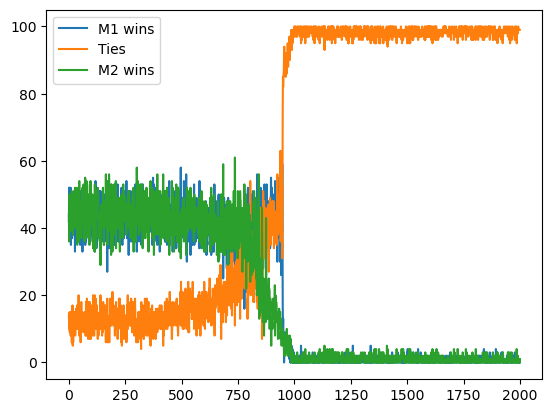

In [ ]:
import matplotlib.pyplot as plt

# Plot average performance of the agents
plt.plot(m1_wins, label="M1 wins")
plt.plot(ties, label="Ties")
plt.plot(m2_wins, label="M2 wins")
plt.legend()
plt.show()

In [13]:
# To play against the bot

# convert player input into board cell
def convert_input(input:str):
    cell = 0
    if input[0] == 'a':
        cell += 0
    elif input[0] == 'b':
        cell += 1
    elif input[0] == 'c':
        cell += 2
    else:
        return -1

    if input[1] == '1':
        cell += 0
    elif input[1] == '2':
        cell += 3
    elif input[1] == '3':
        cell += 6
    else:
        return -1
    return cell

board = Tris()

# choose who play first
if random.uniform(0, 1) < 0.5:
    player_turn = True
else:
    player_turn = False

# start game
while board.is_playing():
    print(board)
    if player_turn:
        print("Player turn:")
        print("Seleziona la casella(ex:\"a1\"):")
        action = convert_input(input())
        if action == -1 or action not in board.available_actions():
            continue
        new_board = board.step(action, "O")
    else:
        print("TrAIs turn:")
        action = model1.get_action(board)
        new_board = board.step(action, model1.sign)
        print(model1.qTable[board.get_hash()])

    board = new_board
    player_turn = not player_turn

print(board)
winner = board.check_winner()

if winner == ' ':
    print("It's a draw!")
elif winner == model1.sign:
    print("TrAIs wins!")
else:
    print("Player wins!")

  A B C
1  | | 
  -+-+-
2  | | 
  -+-+-
3  | | 
Player turn:
Seleziona la casella(ex:"a1"):
  A B C
1 O| | 
  -+-+-
2  | | 
  -+-+-
3  | | 
TrAIs turn:
[-1.00000000e+05 -1.06532469e+00  6.95825466e-01 -5.26127601e+00
  9.61350698e+00 -3.71024510e+00 -2.44594795e-01 -1.46580654e+00
  5.47251844e+00]
  A B C
1 O| | 
  -+-+-
2  |X| 
  -+-+-
3  | | 
Player turn:
Seleziona la casella(ex:"a1"):
  A B C
1 O| | 
  -+-+-
2  |X| 
  -+-+-
3  | |O
TrAIs turn:
[ 0.6         2.41708181 -0.18885977 17.26643867  0.6        -0.34579852
  5.7108663   5.02128221  0.6       ]
  A B C
1 O| | 
  -+-+-
2 X|X| 
  -+-+-
3  | |O
Player turn:
Seleziona la casella(ex:"a1"):
  A B C
1 O| | 
  -+-+-
2 X|X| 
  -+-+-
3  | |O
TrAIs turn:
[ 0.6        -1.61768852 10.50621313  0.6         0.6        10.54
 10.34243468 -3.22281485  0.6       ]
  A B C
1 O| | 
  -+-+-
2 X|X|X
  -+-+-
3  | |O
TrAIs wins!
